# Optimal Driving - Deterministic Trajectories

This notebook produces stacked trajectory plots for the determinsitic light length problems in the Optimal Driving framework.

## Import Statements:

In [1]:
import numpy as np
import matplotlib.style as style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from mpl_toolkits import mplot3d
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import math
import os
import sys

### In-text plots toggle:

Uncomment the code in the cell below to view the plots in a separate window.

In [2]:
#%matplotlib qt

## Problem Selection:

Select problem results to view according to numbering scheme:

    1. Stationary (Phase $G$).
    2. Red-Green.
    3. Yellow-Red-Green.

In [3]:
indexChoices = [1,2,3]
problemSelector = int(input("Problem Number: ")) #user specified timeslice to plot
if problemSelector not in indexChoices: 
    print ("No such problem index, invalid choice'")
    sys.exit() #kill the program if user-specified N is out of bounds

Problem Number: 2


## Read In Parameters:

In [4]:
paramFileName = 'FileName'

if problemSelector == 1:
    paramFileName = '../output/stationary_params'
elif problemSelector == 2:
    paramFileName = '../output/rg_params'
elif problemSelector == 3:
    paramFileName = '../output/yrg_params'

In [5]:
gInUncertainGreenPhase = 1; 

with open('%s.txt' %paramFileName) as f:    
    
    #Parameter Key
    paramKey = f.readline()
    #paramVals = [float(num) for num in line1.split(' ')]
    
    #Param values
    line2 = f.readline()
    paramVals = [float(num) for num in line2.split(' ')]
    
    line3 =f.readline()
    
    #Uncertain green info
    line4 = f.readline()
    stochLightInfo = [float(num) for num in line4.split(' ')]
    
    line5 = f.readline()
    
    #Sampling info (not currently used)
    line6 = f.readline()
    samplingInfo = [float(num) for num in line6.split(' ')]

### Parameter Definitions:

In [6]:
gDPos = paramVals[0]

gDVel = paramVals[1]

gDT = paramVals[2]

gDMax = paramVals[3]

gVMax = paramVals[4]

gDTarget = paramVals[5]

gLightLength = paramVals[6]

gDNum = int(paramVals[7])

gVNum = int(paramVals[8])

gNt = int(paramVals[9])

gAlpha = paramVals[10]

gBeta = paramVals[11]

gTG = paramVals[12]

gTR = paramVals[13]

gTerminalT = paramVals[14]
print("Terminal Time: ", gTerminalT)
gAccelInfty = paramVals[15]

gN = gVNum #how it's set in code 

gInfty = 10000000 

forbiddenAccel = np.nan

##========================================STOCHASTIC LIGHT INFO====================================================
if gInUncertainGreenPhase == 1:
    gTY1 = stochLightInfo[0]
    gTY2 = stochLightInfo[1]
    gTYP1 = stochLightInfo[2]
    gTYP2 = stochLightInfo[3]
    gYellowDuration = stochLightInfo[4]
    gRedDuration = stochLightInfo[5]
    gTR = stochLightInfo[6]
    gTG = stochLightInfo[7]

##=======================================SAMPLING DETAILS==========================================================
gSamplingTNumThresh = samplingInfo[0]
gSliceSampleSpacing = samplingInfo[1]

if (gNt < gSamplingTNumThresh):
    gSliceSampleSpacing = 1
       
maxSliceIndex = gNt / gSliceSampleSpacing

print("Maximum Time Index: ", maxSliceIndex)

prohibitedVal = gAccelInfty

Terminal Time:  60.0
Maximum Time Index:  2400.0


## Trajectory Plotting:

### Data Processing:

In [7]:
traj1FileName = 'FileName'
traj2FileName = 'FileName'

if problemSelector == 1:
    traj1FileName = '../output/stationary_opt_trajectory_d80.00v0.00.txt'
elif problemSelector == 2:
    traj1FileName = '../output/rg_opt_trajectory_d80.00v15.00.txt'
    traj2FileName = '../output/rg_opt_trajectory_d80.00v0.00.txt'
elif problemSelector == 3:
    traj1FileName = '../output/yrg_opt_trajectory_d43.00v10.00.txt'
    traj2FileName = '../output/yrg_opt_trajectory_d48.00v10.00.txt'

In [8]:
mpl.rcParams['font.size'] = 18

#Read txt file and sort each line into its own list
with open(traj1FileName) as f:
    
    #Position values
    line1 = f.readline()
    positionTraj1 = [float(num) for num in line1.split(' ')]
    #print(position)
    #Velocity values
    line2 = f.readline()
    velocityTraj1 = [float(num) for num in line2.split(' ')]
    #print(velocity)
    #Time values 
    line3 = f.readline()
    timeTraj1 = [float(num) for num in line3.split(' ')]
    #print(time)
    #OC Values 
    line4 = f.readline()
    optimalControlTraj1 = [float(num) for num in line4.split(' ')]
    #print(optimalControl)
if problemSelector > 1:
    with open(traj2FileName) as g:
        #Position values
        line1 = g.readline()
        positionTraj2 = [float(num) for num in line1.split(' ')]
        #print(position)
        #Velocity values
        line2 = g.readline()
        velocityTraj2 = [float(num) for num in line2.split(' ')]
        #print(velocity)
        #Time values 
        line3 = g.readline()
        timeTraj2 = [float(num) for num in line3.split(' ')]
        #print(time)
        #OC Values 
        line4 = g.readline()
        optimalControlTraj2 = [float(num) for num in line4.split(' ')]

### Plotting Code:

In [9]:
#Plot horizontal axis
fullHorizAxis = []

minV = []
turningGreenT = []
turningRedT = []

firstTraj = 0
timeForHorizAxis = []

if problemSelector > 1:
    maxTime = max(timeTraj1[-1], timeTraj2[-1])
    if maxTime == timeTraj1[-1] and problemSelector > 1:
        firstTraj = 1
        timeForHorizAxis = timeTraj1
    else:
        timeForHorizAxis = timeTraj2
else:
    timeForHorizAxis = timeTraj1
for i in range (0, len(timeForHorizAxis)):
    numPts = len(timeForHorizAxis)
    spacing = (gDMax - gDTarget) / numPts
    posVal = i * spacing 
    fullHorizAxis.append(posVal)

vertAxis = np.linspace(gDTarget - 1, gDMax + 1, int(gDNum+1))

for i in range (0, len(fullHorizAxis)):
    minV.append(0)
    
for i in range (0, len(vertAxis)):
    turningGreenT.append(gTG)
    turningRedT.append(gTR)


<Figure size 432x288 with 0 Axes>

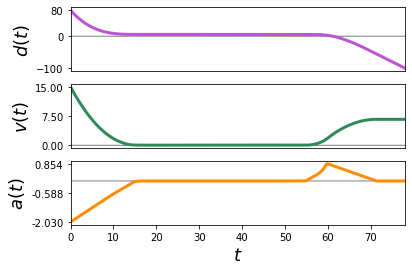

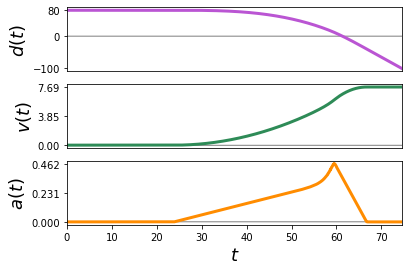

In [10]:
plt.figure(1)
initialPos = positionTraj1[0]
initialVel = velocityTraj1[0]

controlMidpt = (min(optimalControlTraj1) + max(optimalControlTraj1)) * 0.5
dYTicks = [gDTarget, 0, positionTraj1[0]]
vYTicks = [0, 0.5 * max(velocityTraj1), max(velocityTraj1)]
aYTicks = [min(optimalControlTraj1), controlMidpt, max(optimalControlTraj1)]
#aYTicks = [0, controlMidpt, max(optimalControl)]
fig, axs = plt.subplots(3)
#fig.suptitle('$x^{*}(t), a^{*}(t)$ for $d_0 = %0.1f m, v_0 = %0.1f m/s$' %(initialPos, initialVel))

## Position ---------------------------------------------------
axs[0].plot(fullHorizAxis, minV, color = 'black', linewidth = 0.5)
axs[0].plot(timeTraj1, positionTraj1,color= 'mediumorchid', linewidth=3, label='Position')
axs[0].set_xlim([min(timeTraj1), max(timeTraj1)])
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks(dYTicks)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].set_ylabel("$d(t)$")

## Velocity ---------------------------------------------------
axs[1].plot(fullHorizAxis, minV, color = 'black', linewidth = 0.5)
axs[1].plot(timeTraj1, velocityTraj1,color='seagreen', linewidth=3, label='Velocity')
axs[1].set_xlim([min(timeTraj1), max(timeTraj1)])
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks(vYTicks)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_ylabel("$v(t)$")

## Acceleration ---------------------------------------------------
axs[2].plot(fullHorizAxis, minV, color = 'black', linewidth = 0.5)
axs[2].plot(timeTraj1, optimalControlTraj1,color='darkorange', linewidth=3, label='a* (computed)')
axs[2].set_xlim([min(timeTraj1), max(timeTraj1)])
axs[2].set_ylabel("$a(t)$")
axs[2].get_yaxis().set_ticks(aYTicks)
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axs[2].tick_params(axis='both', which='major', labelsize=10)
axs[2].set_xlabel("$t$")

if problemSelector > 1:
    plt.figure(2)
    initialPos = positionTraj2[0]
    initialVel = velocityTraj2[0]

    controlMidpt = (min(optimalControlTraj2) + max(optimalControlTraj2)) * 0.5
    dYTicks = [gDTarget, 0, positionTraj2[0]]
    vYTicks = [0, 0.5 * max(velocityTraj2), max(velocityTraj2)]
    aYTicks = [min(optimalControlTraj2), controlMidpt, max(optimalControlTraj2)]
    #aYTicks = [0, controlMidpt, max(optimalControl)]
    fig, axs = plt.subplots(3)
    #fig.suptitle('$x^{*}(t), a^{*}(t)$ for $d_0 = %0.1f m, v_0 = %0.1f m/s$' %(initialPos, initialVel))

    ## Position ---------------------------------------------------
    axs[0].plot(fullHorizAxis, minV, color = 'black', linewidth = 0.5)
    axs[0].plot(timeTraj2,positionTraj2,color= 'mediumorchid', linewidth=3, label='Position')
    axs[0].set_xlim([min(timeTraj2), max(timeTraj2)])
    axs[0].get_xaxis().set_ticks([])
    axs[0].get_yaxis().set_ticks(dYTicks)
    axs[0].tick_params(axis='both', which='major', labelsize=10)
    axs[0].set_ylabel("$d(t)$")

    ## Velocity ---------------------------------------------------
    axs[1].plot(fullHorizAxis, minV, color = 'black', linewidth = 0.5)
    axs[1].plot(timeTraj2,velocityTraj2,color='seagreen', linewidth=3, label='Velocity')
    axs[1].set_xlim([min(timeTraj2), max(timeTraj2)])
    axs[1].get_xaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks(vYTicks)
    axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[1].tick_params(axis='both', which='major', labelsize=10)
    axs[1].set_ylabel("$v(t)$")

    ## Acceleration ---------------------------------------------------
    axs[2].plot(fullHorizAxis, minV, color = 'black', linewidth = 0.5)
    axs[2].plot(timeTraj2,optimalControlTraj2,color='darkorange', linewidth=3, label='a* (computed)')
    axs[2].set_xlim([min(timeTraj2), max(timeTraj2)])
    axs[2].set_ylabel("$a(t)$")
    axs[2].get_yaxis().set_ticks(aYTicks)
    axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[2].tick_params(axis='both', which='major', labelsize=10)
    axs[2].set_xlabel("$t$")


## Heatmaps with Trajectory Starting Points:

This section produces heatmap(s) of the feedback controls at $t=0$ corresponding to the selected problem and marks the trajectory starting $(d,v)$ with an X.

### Data Processing:

In [14]:
fileName = 'FileName'
fileName2 = 'FileName'
fileName3 = 'FileName'
if problemSelector == 1:
    fileName = '../output/stationary_oc'
elif problemSelector == 2:
    fileName = '../output/rg_oc'
elif problemSelector == 3:
    fileName = '../output/yrg_oc_c2_0.33'

In [15]:
## list of lists - each row from each matrix (starting from t=0) is stored as its own list in data, 
data = np.loadtxt('%s.txt' %fileName) 
data2 = np.loadtxt('%s.txt' %fileName) 
data3 = np.loadtxt('%s.txt' %fileName) 

#start = int(sampleSlice * (gDNum + 1))
start = 0
end = int(start + gDNum + 1)

#extract the matrix for the user specifed slice 
plottingData = data[start:end]

#flip the plotting data correctly to plot starting from the bottom left corner
plottingData = np.transpose(plottingData) #rows first become columns 

plottingData = np.flip(plottingData,0) #order of the columns are flipped to start from bottom up

#Go through data and reset accel infty to nan
for j in range (0, gVNum):
    for i in range (0, gDNum):
        if plottingData[j][i] == prohibitedVal:
            nanVal = np.nan
            plottingData[j][i] = nanVal

### Plotting Code:

0.0


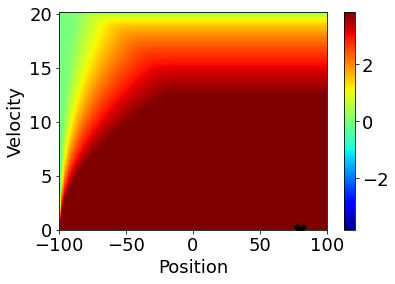

In [16]:
##----------------Plotting Code----------------------------##
plt.figure(1)
timeVal = 0 #starting t

currentT = 0 * gDT #Note: Hard-coded t = 0 

##---------------------Max accel line--------------------------------------
timeToRed = gTR - currentT
vCritical = gVMax - gBeta * timeToRed
vThreshLinear = gAlpha * timeToRed * (1 + np.sqrt(1 + (gBeta / gAlpha)))
parabExtensionA = (gBeta + gAlpha) / (2 * gAlpha * gBeta)
parabExtensionB = -gVMax / gBeta
parabExtensionC = (gVMax**2) / (2 * gBeta) -timeToRed * gVMax
parabExtensionVelThresh = (-parabExtensionB + np.sqrt((parabExtensionB**2) - 4 *parabExtensionA * parabExtensionC)) / (2 * parabExtensionA)
vThreshParab = (-parabExtensionB + np.sqrt((parabExtensionB**2) - 4 *parabExtensionA * parabExtensionC)) / (2 * parabExtensionA);
officialVThresh = vThreshLinear
if vCritical < vThreshLinear:
    officialVThresh = vThreshParab 
print(currentT)
maxAccelLine = []
velVals = np.linspace(0, gVMax, gVNum)
for i in range (0, len(velVals)):
    v = velVals[i]
    d = 0
    timeToMaxV = (gVMax - v)
    if v < vCritical:
        d = v * (gTR - currentT) + 0.5*gBeta * (gTR - currentT)**2
    else:
        d = (-(v**2) / (2 * gBeta)) + ((v * gVMax) / gBeta) - (0.5 * (gVMax**2) / gBeta) + timeToRed*gVMax  
    maxAccelLine.append(d)
    
#First trajectory starting point
d0 = positionTraj1[0]
v0 = velocityTraj1[0]
       
fig = plt.gcf()
ax = fig.add_subplot(1,1,1)
im = plt.imshow(plottingData, cmap=plt.get_cmap('jet'), vmin = gAccelInfty, vmax = gAlpha, extent=[gDTarget,gDMax,0,gVMax], interpolation='nearest')
point1, = ax.plot(d0,v0, marker="X", ms = 12, color = 'black')
plt.clim([-gAlpha, gBeta]) #colorbar colors 
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.colorbar() 
plt.gca().set_aspect('auto')
plt.show()

if problemSelector > 1:
    d0Traj2 = positionTraj2[0]
    v0Traj2 = velocityTraj2[0]
    plt.figure(2)
    fig = plt.gcf()
    ax = fig.add_subplot(1,1,1)
    im = plt.imshow(plottingData, cmap=plt.get_cmap('jet'), vmin = gAccelInfty, vmax = gAlpha, extent=[gDTarget,gDMax,0,gVMax], interpolation='nearest')
    point1, = ax.plot(d0Traj2,v0Traj2, marker="X", ms = 12, color = 'black')
    plt.clim([-gAlpha, gBeta]) #colorbar colors 
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.colorbar() 
    plt.gca().set_aspect('auto')
    plt.show()

if problemSelector == 3:
    d0Traj2 = positionTraj2[0]
    v0Traj2 = velocityTraj2[0]
    plt.figure(3)
    fig = plt.gcf()
    ax = fig.add_subplot(1,1,1)
    im = plt.imshow(plottingData, cmap=plt.get_cmap('jet'), vmin = gAccelInfty, vmax = gAlpha, extent=[gDTarget,gDMax,0,gVMax], interpolation='nearest')
    point, = ax.plot(d0,v0, marker="X", ms = 8, color = 'white')
    point1, = ax.plot(d0Traj2,v0Traj2, marker="X", ms = 8, color = 'black')
    plt.clim([-gAlpha, gBeta]) 
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.colorbar() 
    plt.gca().set_aspect('auto')
    plt.show()